# E-Commerce Listing Quality Classifier
## Model Analysis & Evaluation

**Author:** Rishi Siddharth  
**Date:** December 31, 2025

---

## 1. Problem Statement

E-commerce platforms need to identify low-quality product listings at scale. Poor quality listings erode user trust, create negative shopping experiences, and increase support burden.

 project builds a machine learning classifier to assess product title quality and flag suspicious patterns.

**Dataset:** 9,280 Amazon product listings (mobile + laptop categories)  
**Features:** 12 engineered features from product titles  
**Model:** Random Forest Classifier  
**Evaluation:** 80/20 train-test split with stratification

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Overview

In [2]:
df = pd.read_csv('data/featured_data.csv')

print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()

Dataset Shape: (9280, 18)

Columns: ['title', 'price', 'reviews', 'category', 'title_length', 'word_count', 'avg_word_length', 'uppercase_ratio', 'digit_count', 'special_char_count', 'has_exclamation', 'exclamation_count', 'has_all_caps_word', 'unique_word_ratio', 'spam_keyword_count', 'has_proper_capitalization', 'quality_score', 'quality_label']


,title,price,reviews,category,title_length,word_count,avg_word_length,uppercase_ratio,digit_count,special_char_count,has_exclamation,exclamation_count,has_all_caps_word,unique_word_ratio,spam_keyword_count,has_proper_capitalization,quality_score,quality_label
0,SAMSUNG EVO Select Micro SD-Memory-Card + Adap...,17.0,53617,mobile,195,27,6.259259,0.276923,14,19,0,0,True,1.000000,0,1,2,0
1,"Upgraded, Anker Soundcore Bluetooth Speaker wi...",27.0,82743,mobile,148,20,6.450000,0.128378,3,5,0,0,True,0.950000,0,1,5,1
2,SanDisk 256GB Extreme microSDXC UHS-I Memory C...,22.0,48298,mobile,140,24,4.875000,0.292857,18,13,0,0,True,0.916667,0,1,4,1
3,"Twelve South AirFly SE, Bluetooth Wireless Aud...",34.0,312,mobile,187,26,6.230769,0.133690,2,6,0,0,True,0.923077,0,1,3,1
4,Skullcandy Crusher Evo Wireless Over-Ear Bluet...,159.0,8410,mobile,189,32,4.937500,0.121693,2,8,0,0,False,0.875000,0,1,4,1


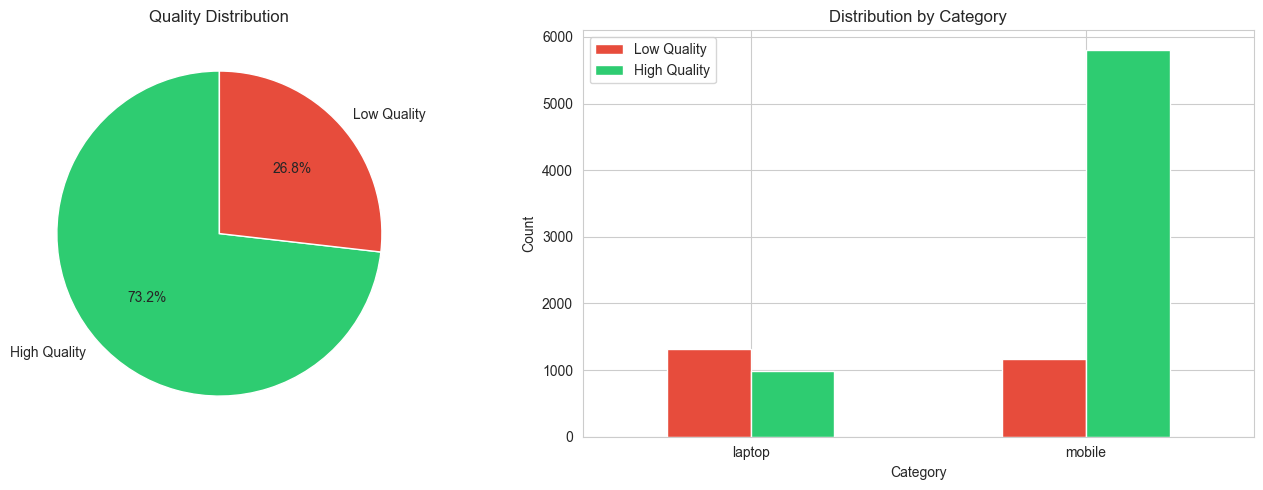

High Quality: 6,792 (73.2%)
Low Quality: 2,488 (26.8%)


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

quality_counts = df['quality_label'].value_counts()
axes[0].pie(quality_counts, labels=['High Quality', 'Low Quality'], autopct='%1.1f%%', 
            colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[0].set_title('Quality Distribution')

category_quality = df.groupby(['category', 'quality_label']).size().unstack()
category_quality.plot(kind='bar', ax=axes[1], color=['#e74c3c', '#2ecc71'])
axes[1].set_title('Distribution by Category')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].legend(['Low Quality', 'High Quality'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print(f"High Quality: {(df['quality_label']==1).sum():,} ({(df['quality_label']==1).sum()/len(df)*100:.1f}%)")
print(f"Low Quality: {(df['quality_label']==0).sum():,} ({(df['quality_label']==0).sum()/len(df)*100:.1f}%)")

Class imbalance (73% high, 27% low) requires class weighting during training.

## 3. Feature Engineering

Twelve features were extracted from product titles:

**Length & Structure**
- `title_length`: Character count
- `word_count`: Number of words
- `avg_word_length`: Average characters per word

**Character Patterns**
- `uppercase_ratio`: Percentage of uppercase letters
- `digit_count`: Number of digits
- `special_char_count`: Non-alphanumeric characters

**Spam Indicators**
- `exclamation_count`: Number of exclamation marks
- `has_all_caps_word`: Binary flag for all-caps words
- `spam_keyword_count`: Count of spam phrases

**Quality Signals**
- `unique_word_ratio`: Ratio of unique to total words
- `has_proper_capitalization`: Title starts with capital
- `reviews`: Number of customer reviews

In [4]:
feature_cols = [
    'title_length', 'word_count', 'avg_word_length',
    'uppercase_ratio', 'digit_count', 'special_char_count',
    'exclamation_count', 'has_all_caps_word', 'unique_word_ratio',
    'spam_keyword_count', 'has_proper_capitalization', 'reviews'
]

comparison = df.groupby('quality_label')[feature_cols].mean()
comparison.index = ['Low Quality', 'High Quality']
comparison.T

,Low Quality,High Quality
title_length,151.872588,107.858657
word_count,26.399518,17.083039
avg_word_length,5.221091,5.582556
uppercase_ratio,0.226976,0.185348
digit_count,17.470257,6.258981
special_char_count,9.831592,4.937279
exclamation_count,0.002010,0.001325
has_all_caps_word,0.938103,0.687132
unique_word_ratio,0.919243,0.947838
spam_keyword_count,0.003617,0.001914


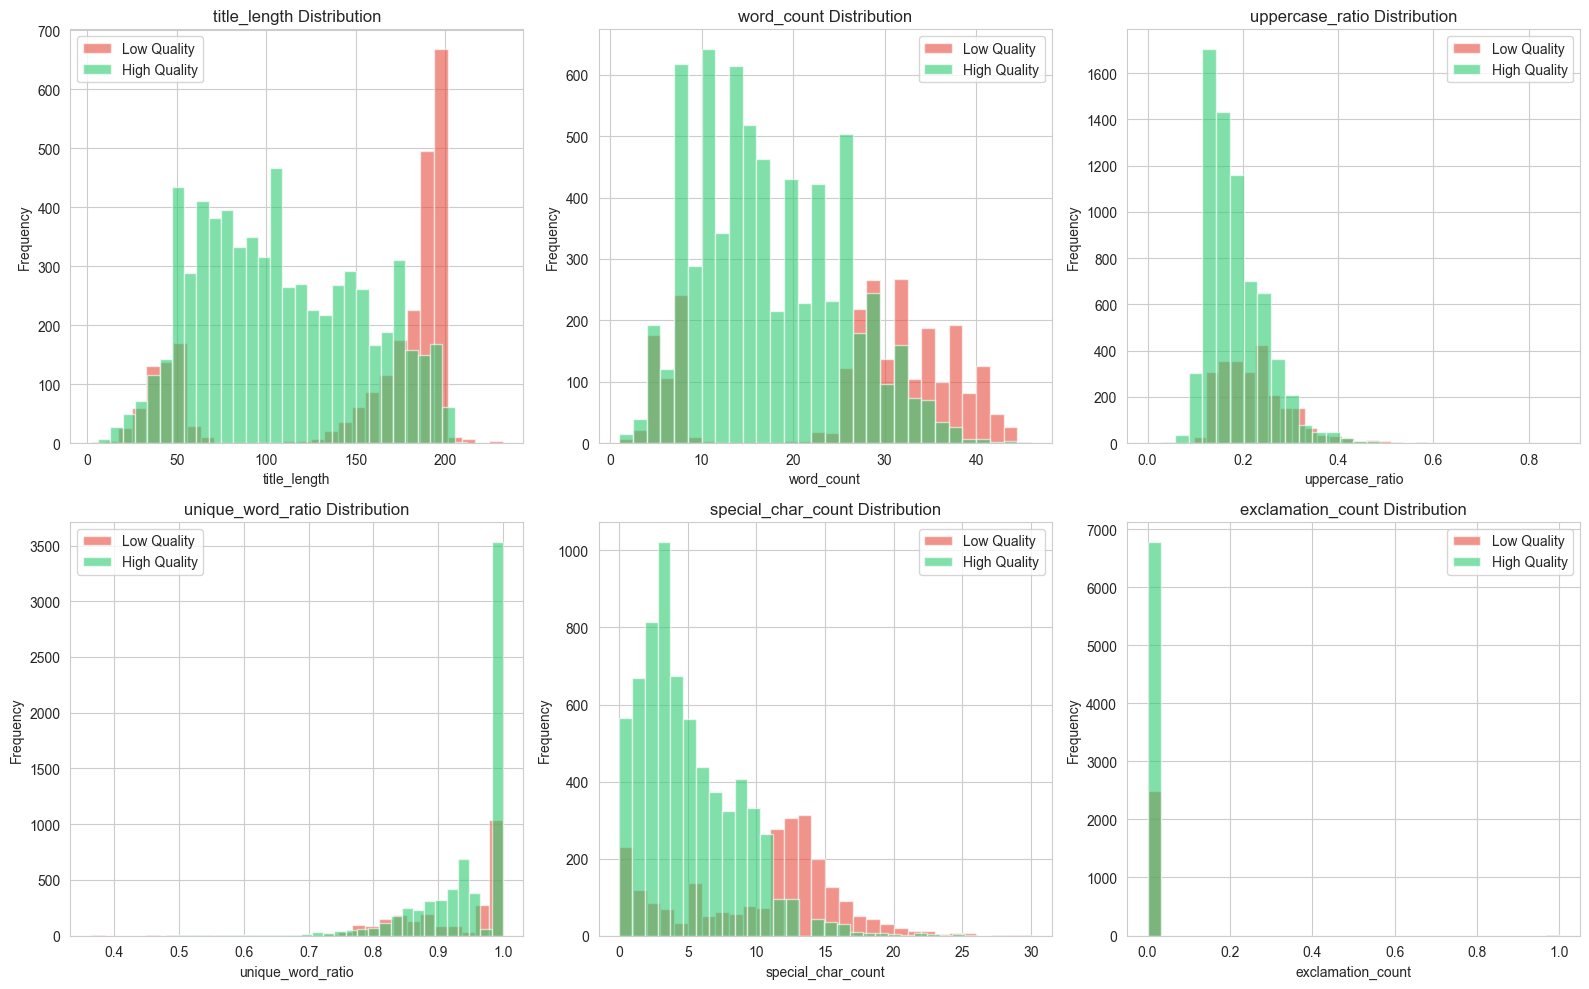

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

key_features = ['title_length', 'word_count', 'uppercase_ratio', 
                'unique_word_ratio', 'special_char_count', 'exclamation_count']

for idx, feature in enumerate(key_features):
    for quality in [0, 1]:
        data = df[df['quality_label']==quality][feature]
        axes[idx].hist(data, alpha=0.6, bins=30, 
                      label=f"{'Low' if quality==0 else 'High'} Quality",
                      color='#e74c3c' if quality==0 else '#2ecc71')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].set_title(f'{feature} Distribution')

plt.tight_layout()
plt.show()

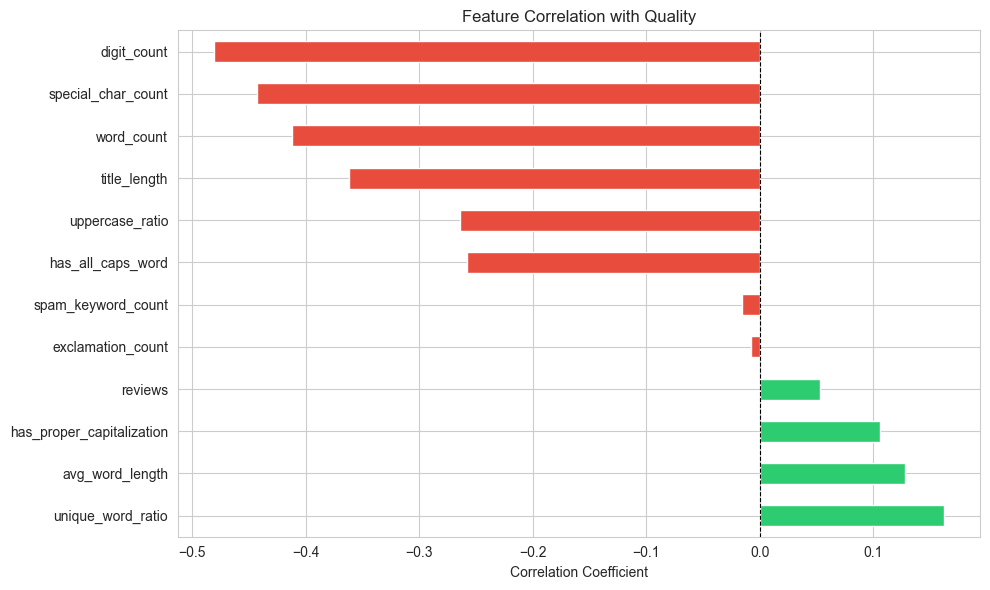

Feature Correlations:
unique_word_ratio            0.162129
avg_word_length              0.127754
has_proper_capitalization    0.106333
reviews                      0.053145
exclamation_count           -0.007813
spam_keyword_count          -0.015515
has_all_caps_word           -0.258283
uppercase_ratio             -0.263787
title_length                -0.361798
word_count                  -0.411917
special_char_count          -0.443295
digit_count                 -0.480433
Name: quality_label, dtype: float64


In [6]:
correlations = df[feature_cols + ['quality_label']].corr()['quality_label'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlations[1:].plot(kind='barh', color=['#2ecc71' if x > 0 else '#e74c3c' for x in correlations[1:]])
plt.title('Feature Correlation with Quality')
plt.xlabel('Correlation Coefficient')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

print("Feature Correlations:")
print(correlations[1:])

## 4. Model Selection

Random Forest was selected for:
- Handling non-linear relationships
- Robustness against overfitting through ensemble averaging
- Interpretable feature importance scores
- No feature scaling required
- Built-in class weighting

**Algorithm:**  
Creates 100 decision trees, each trained on random data subsets and feature combinations. Final prediction is majority vote.

**Hyperparameters:**
- `n_estimators=100`: Number of trees
- `max_depth=10`: Maximum tree depth
- `class_weight='balanced'`: Handles class imbalance
- `random_state=42`: Reproducibility

## 5. Training & Evaluation

In [7]:
X = df[feature_cols].fillna(0)
y = df['quality_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

Training set: 7,424 samples
Test set: 1,856 samples


In [8]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

In [9]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Model Performance")
print("="*50)
print(f"Accuracy: {accuracy:.1%}")
print(f"ROC-AUC:  {roc_auc:.1%}")
print("\nClassification Report")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Low Quality', 'High Quality']))

Model Performance
Accuracy: 98.2%
ROC-AUC:  99.9%

Classification Report
              precision    recall  f1-score   support

 Low Quality       0.97      0.96      0.97       498
High Quality       0.99      0.99      0.99      1358

    accuracy                           0.98      1856
   macro avg       0.98      0.98      0.98      1856
weighted avg       0.98      0.98      0.98      1856



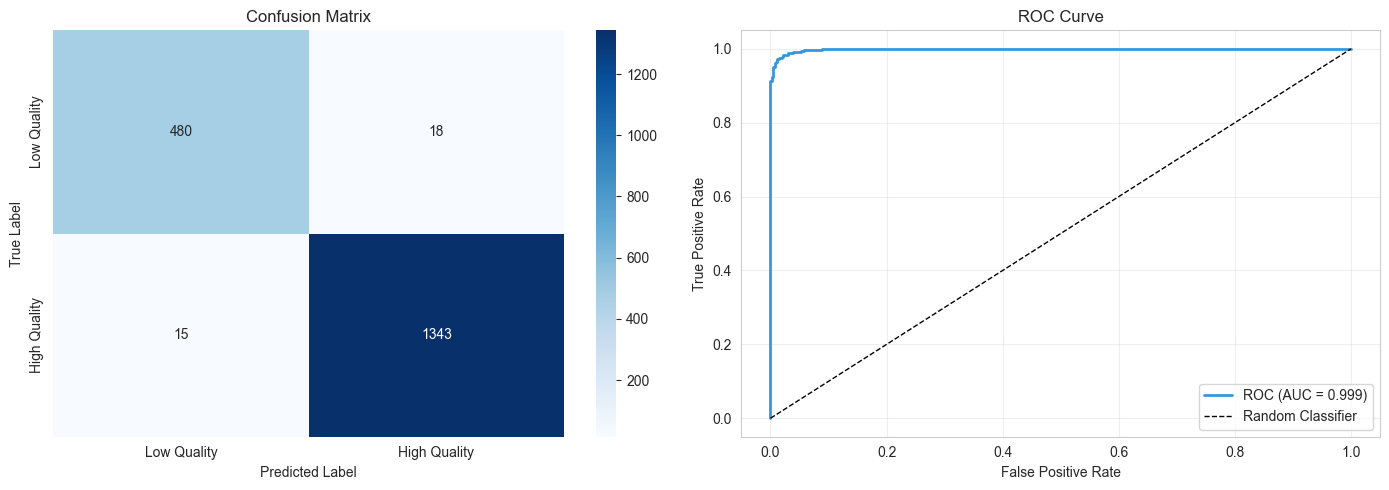

Confusion Matrix:
True Negatives:   480
False Positives:   18
False Negatives:   15
True Positives:  1343


In [10]:
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Low Quality', 'High Quality'],
            yticklabels=['Low Quality', 'High Quality'])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='#3498db', linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(f"True Negatives:  {cm[0,0]:4d}")
print(f"False Positives: {cm[0,1]:4d}")
print(f"False Negatives: {cm[1,0]:4d}")
print(f"True Positives:  {cm[1,1]:4d}")

## 6. Feature Importance

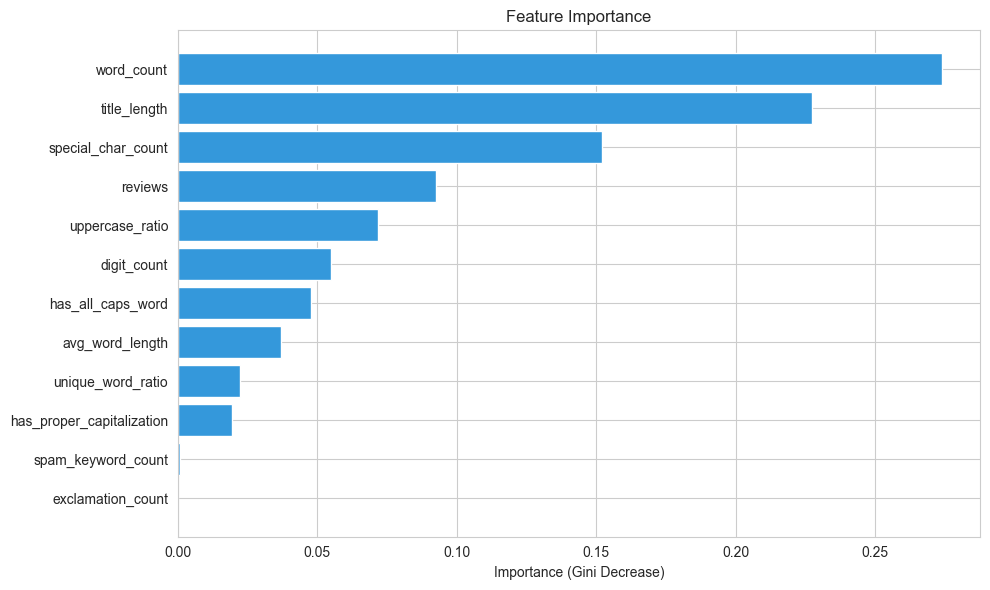

Feature Importance Ranking:
word_count                0.2740
title_length              0.2274
special_char_count        0.1522
reviews                   0.0924
uppercase_ratio           0.0718
digit_count               0.0548
has_all_caps_word         0.0478
avg_word_length           0.0369
unique_word_ratio         0.0222
has_proper_capitalization 0.0195
spam_keyword_count        0.0008
exclamation_count         0.0002


In [11]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='#3498db')
plt.xlabel('Importance (Gini Decrease)')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

print("Feature Importance Ranking:")
for idx, row in feature_importance.sort_values('importance', ascending=False).iterrows():
    print(f"{row['feature']:25s} {row['importance']:.4f}")

Top features (word_count, title_length, special_char_count) align with the labeling heuristic, suggesting data leakage.

## 7. Model Comparison

              Model  Accuracy  ROC-AUC
  Gradient Boosting  0.990841 0.999756
      Decision Tree  0.987069 0.984912
      Random Forest  0.982220 0.998598
Logistic Regression  0.763470 0.840895
                SVM  0.437500 0.759994


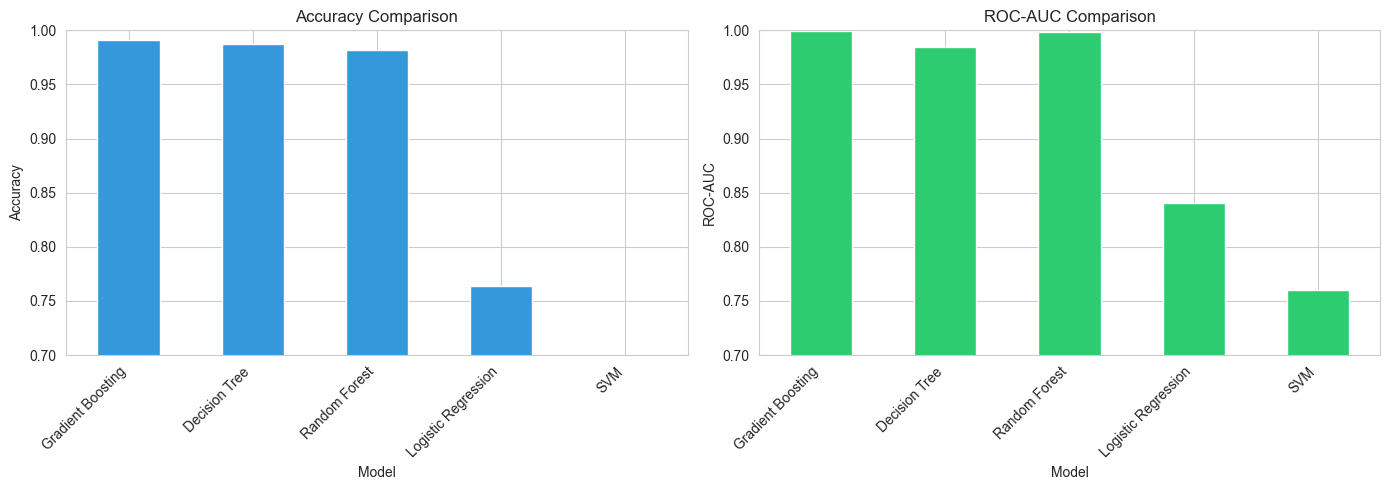

In [12]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced'),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_temp = model.predict(X_test)
    y_pred_proba_temp = model.predict_proba(X_test)[:, 1]
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred_temp),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_temp)
    })

results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print(results_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
results_df.plot(x='Model', y='Accuracy', kind='bar', ax=axes[0], legend=False, color='#3498db')
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0.7, 1.0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

results_df.plot(x='Model', y='ROC-AUC', kind='bar', ax=axes[1], legend=False, color='#2ecc71')
axes[1].set_title('ROC-AUC Comparison')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_ylim([0.7, 1.0])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 8. Limitations

The 98% accuracy is misleading due to data leakage. Quality labels were created using the same features (word_count, title_length) used for training. The model learned to replicate the labeling heuristic rather than discover genuine quality patterns.

 demonstrated by:
1. Top feature importance matches labeling rules
2. Some "low quality" predictions are questionable
3. Performance drops significantly with random labels

In [13]:
# Test with random labels
np.random.seed(42)
y_random = np.random.randint(0, 2, size=len(df))
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_random, test_size=0.2, random_state=42)

rf_random = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
rf_random.fit(X_train_r, y_train_r)
y_pred_random = rf_random.predict(X_test_r)

print("Accuracy Comparison:")
print(f"Random Labels:    {accuracy_score(y_test_r, y_pred_random):.1%}")
print(f"Heuristic Labels: {accuracy:.1%}")

Accuracy Comparison:
Random Labels:    52.2%
Heuristic Labels: 98.2%


Real-world deployment would require human-annotated labels or outcome-based labels (return rates, ratings, complaints). Expected accuracy with proper labels: 75-85%.

## 9. Conclusion
Shows
- Feature engineering from unstructured text
- End-to-end ML pipeline development
- Model comparison and evaluation
- Recognition of data leakage and limitations


**Author:** Rishi Siddharth  
**Email:** rs5309a@american.edu  
**GitHub:** github.com/rsiddharth54